<a href="https://colab.research.google.com/github/tleitch/BDML/blob/main/LC%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr style="height:2pt">

**Install below package using terminal**

"conda install -c glemaitre imbalanced-learn"

In [1]:
!pip install --upgrade pip
!pip install -U sklearn
!pip install imblearn
!pip install textblob
!pip install -U imbalanced-learn
!pip install xgboost
!pip install -U seaborn

     |████████████████████████████████| 1.5MB 8.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 206 kB 8.7 MB/s 
     |████████████████████████████████| 22.3 MB 67.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display

import random

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.svm import SVC 
from xgboost.sklearn import XGBClassifier 
import itertools
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from textblob import Word
from sklearn.ensemble import VotingClassifier 

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Prediction of Charge-Offs

We will consider the loan status as the response variable, a binary outcome for a loan with value 0 for fully paid and 1 for Charged Off.

We will work with data previously cleaned and augmented with census information. We will use a subset of loans which were fully paid or charged-off.

In [5]:
np.random.seed(9999)

In [6]:
# Entire data - please use this data set when you run it on AWS or a powerful machine.
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015.csv')

# 1% of the data
# 1% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015_10.csv').sample(frac=.1) 

# 10% of the data
# 10% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
df_loan_accepted_census_cleaned = pd.read_csv('https://s3.amazonaws.com/ruxton.ai/df_loan_accepted_census_cleaned.csv')

In [7]:
df_loan = df_loan_accepted_census_cleaned.copy()
df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]

## Features Selection

Our goal is now to do exploratory analysis using predictive models in order to find important features in closed loans.

Statistical tests can be used to select features that have the strongest relationship with the response variable. 

The Recursive Feature Elimination works by recursively removing variables and building a model on those variables that remain. Model accuracy is used to select the variables which contribute the most to the response.

In this section we use a model-based approach of features selection using bagged trees and PCA. 



### Manual features selection

Using domain knowledge, we remove a list of features as manual feature selection. 
The following list of predictors are those which we MUST not use since they are data gathered AFTER the loan is funded. The reason to exclude them is because these features will not be available in unseen future dataset. Those features are highly correlated to charged-off loans and would otherwise bias our results.

In [8]:
not_predictor = [
'chargeoff_within_12_mths',   
'collection_recovery_fee',
'debt_settlement_flag',
'debt_settlement_flag_date',
'deferral_term',
'funded_amnt_inv',
'funded_amnt',
'hardship_amount',
'hardship_dpd',
'hardship_end_date',
'hardship_flag',
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type',
'last_credit_pull_d',
'last_fico_range_high',
'last_fico_range_low',
'last_pymnt_amnt',
'last_pymnt_d',
'next_pymnt_d',
'orig_projected_additional_accrued_interest',
'out_prncp',
'out_prncp_inv',
'payment_plan_start_date',
'pymnt_plan',
'recoveries',
'settlement_amount',
'settlement_date',
'settlement_percentage',
'settlement_status',
'settlement_term',
'total_pymnt',
'total_pymnt_inv',
'total_rec_int',
'total_rec_late_fee',
'total_rec_prncp',
'verification_status'
]

**Dropping non-relevant columns**


Features like 'index', 'id', 'url' and so on are dropped as they are not relevant to our goal of loan status prediction.

We drop the index column.

In [9]:
not_predictor  += ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1']

We drop the id, URL

In [10]:
not_predictor  += ['id', 'url']

We drop the employment title, loan title and description, which contains too many distinct values and cannot be easily categorized.

In [11]:
not_predictor += ['emp_title', 'title', 'desc']

We drop the success flag since it contains the same information as the loan status.

In [12]:
not_predictor += ['success']

We remove following the issue date, quarter and year, which is less relevant for future loans, we only keep the issue month (Jan to Dec).

In [13]:
not_predictor += ['issue_q', 'issue_d']

The grade and subgrade are categories which the LendingClub match to interest rates. Although the categories are fixed, the interest rate can slightly change within each category over the time. 

The term is calculated using the amount and the interest rate.

It follows that `int_rate`, `grade`, `sub_grade` are correlated. Furthermore `loan_amnt`, `int_rate` and `term` define the `installment`. These relationships would bring collinearity into our model for features selection.

We will therefore work with `loan_amnt`, `grade`, `sub_grade` and `term`. If it comes out that these features are important for predicting charge-off, we will conclude that their related variables `int_rate`, and `installment` are also important.

In [14]:
not_predictor += ['int_rate', 'installment']

As far as FICO is concerned, there are 6 variables. Four of them are determined at the initial loan application, thus we can use them. It doesn't seem that they are updated. 

These 2 are significant and collinear, so only one needs to be selected. We choose

    - fico_range_high
    - fico_range_low

These 2 are not so significant and, we believe are used for joint applications.

    - sec_app_fico_range_high
    - sec_app_fico_range_low


However, These two are created, and undoubtedly updated, throughout the loan life. They should not be used:

    - last_fico_range_high
    - last_fico_range_low

In [15]:
not_predictor += ['sec_app_fico_range_high', 'sec_app_fico_range_low', 'last_fico_range_high', 'last_fico_range_low']

As our EDA has shown, information related to gender, race, zip code and state can lead to some unfair handling by a predictive model. We will assume here that removing them as predictor would solve this issue. We further assume that the remaining predictors will not be correlated in any way with census information.

In [16]:
not_predictor += ['addr_state','zip_code','Population', 'median_income_2016', 
               'female_pct', 'male_pct', 
               'Black_pct', 'White_pct', 'Native_pct', 'Asian_pct', 'Hispanic_pct', 
               'household_family_pct', 'poverty_level_below_pct', 'Graduate_Degree_pct', 'employment_2016_rate']

#### **Correlation and redundancy**

Features-pairs which correlate by either -1 or +1 can be considered to be redundant. However High absolute correlation does not imply redundancy of features in the context of classification, see textbook [4] . Therefore we will have a closer look at each correlation.

In [17]:
# source code adapted from [5]
def find_high_correlated_features(frame):
    new_corr = frame.corr()
    new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
    new_corr = new_corr.stack()
    print(new_corr[(new_corr > 0.80) | (new_corr < -0.80)])
    
predictor = list(set(df_loan_accepted_census_cleaned.columns.values)-set(not_predictor))
find_high_correlated_features(df_loan_accepted_census_cleaned[predictor])   

open_acc                num_sats                      0.959349
total_bc_limit          total_rev_hi_lim              0.820915
                        bc_open_to_buy                0.855208
num_actv_rev_tl         num_rev_tl_bal_gt_0           0.984812
total_bal_ex_mort       total_il_high_credit_limit    0.887616
fico_range_low          fico_range_high               1.000000
mths_since_last_record  pub_rec_bankruptcies          0.814032
num_op_rev_tl           num_sats                      0.842700
                        open_acc                      0.808957
                        num_rev_tl_bal_gt_0           0.817170
                        num_actv_rev_tl               0.813259
                        num_rev_accts                 0.812411
num_bc_tl               num_rev_accts                 0.853090
tot_cur_bal             tot_hi_cred_lim               0.982460
dtype: float64


In [18]:
not_predictor += ['fico_range_low','num_rev_tl_bal_gt_0', 'num_actv_rev_tl','open_il_12m','open_rv_12m','avg_cur_bal','tot_hi_cred_lim','num_bc_tl']

`fico_range_low` and `fico_range_low` are highly correlated. We keep the high value.

The Number of revolving trades with balance >0 `num_rev_tl_bal_gt_0` and the Number of currently active revolving trades `num_actv_rev_tl` are highly correlated with the Number of currently active bankcard accounts `num_actv_bc_tl`. It is safe to remove the formers for our classification task for identifying fully paid loans from charged-off ones.

The number of open credit lines `open_acc` (preapproved loans between a financial institution and borrower that may be used repeatedly up to a certain limit and can subsequently be paid back prior to payments coming due) in the borrower's credit file is highly correlated with the Number of satisfactory accounts (good standing accounts that have been paid in full and on time) `num_sats`. We will keep both features.

`open_il_24m` and `open_il_12m` are the Number of installment accounts opened in past 24 and 12 months respectively. Both values are strongly correlated. We will consider 24 months period since it includes 12 months period. We will handle `open_rv_12m` and `open_rv_24m` in the same way (Number of revolving trades opened in past 12, resp. 24 months).

`tot_cur_bal`, `avg_cur_bal` Total and average current balance of all accounts are strongly related to `tot_hi_cred_lim`, Total high credit/credit limit. We will only keep the total current balance.

`num_rev_accts` Number of revolving accounts (account created by a lender to represent debts where the outstanding balance does not have to be paid in full every month by the borrower to the lender) and `num_bc_tl` Number of bankcard accounts are correlated. This is because credit cards are usually considered as revolving accounts. We assume that the number of revolving accounts better describe the risk for loans and we will remove the number of bankcard accounts.

`total_bal_ex_mort` Total credit balance excluding mortgage and `total_il_high_credit_limit` Total installment high credit/credit limit are correlated. With an installment account, the borrower pays back the loan plus interest by making regular payments for a fixed amount of time. We will keep both features.

`bc_open_to_buy` Total open to buy on revolving bankcards (credit cards) can be considered as a subset of `total_bc_limit` Total bankcard high credit/credit limit, but both information can differ in many situations. We keep both.

**Features values distribution**

For each remaining feature, we will plot the distribution of their values in both charged-off and fully paid categories. This will help us seing how they might impact the decision boundaries.

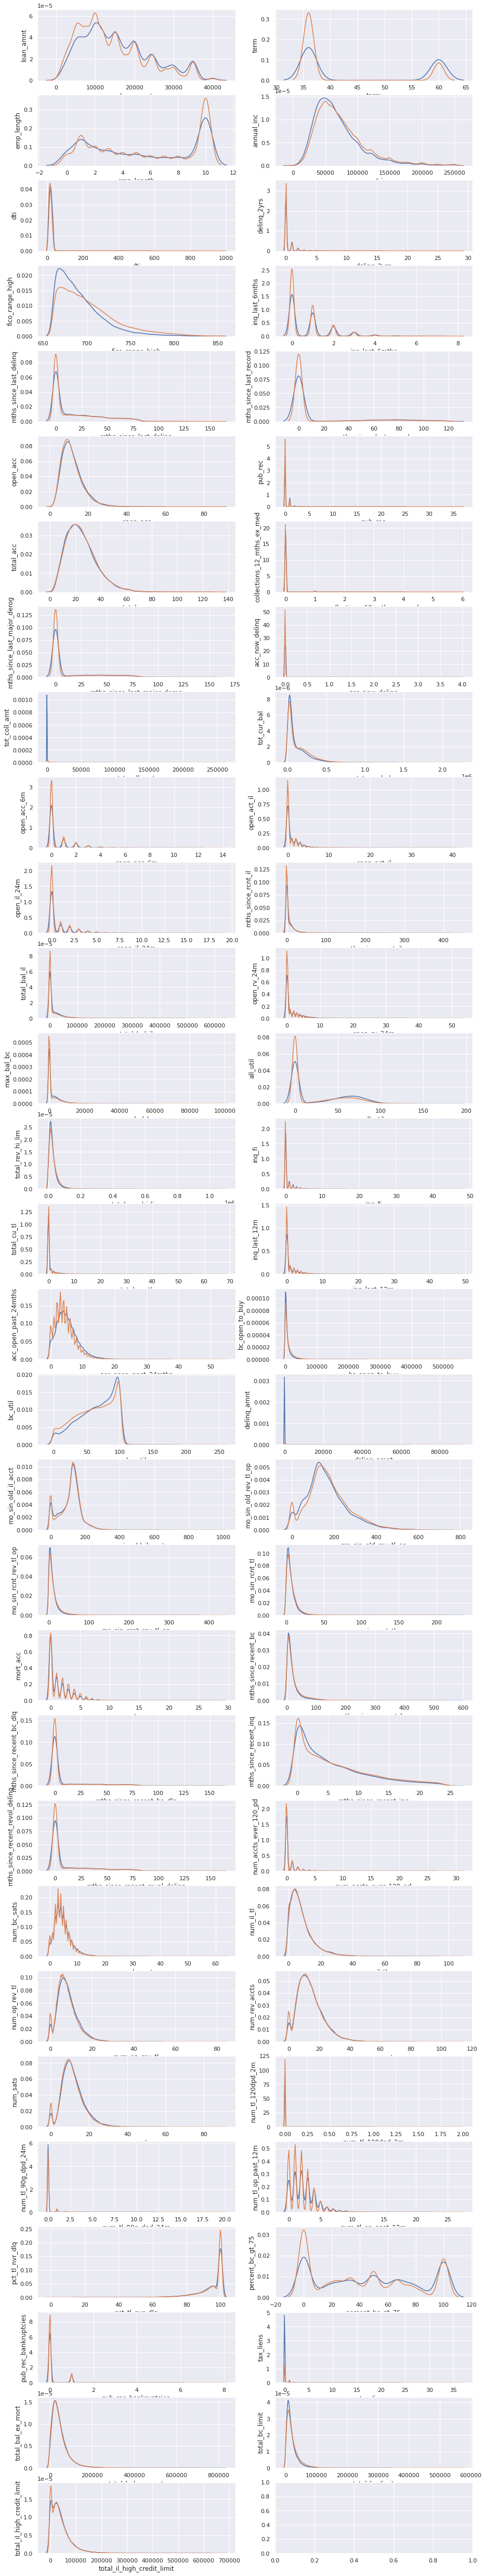

In [19]:
nb = 1
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        nb = nb + 1
fig, ax = plt.subplots(nb//2, 2, figsize=(15,90))
i = 0
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        sns.kdeplot(df_loan[df_loan.loan_status=='Charged Off'][var], label='Charged Off', ax=ax[i//2,i % 2])
        sns.kdeplot(df_loan[df_loan.loan_status!='Charged Off'][var], label='Fully Paid', ax=ax[i//2,i % 2])
        ax[i//2,i % 2].set_ylabel(var)
        i = i + 1
        

Looking at the plots above we see that the distribution for census-related features is almost the same accross both classes of loans. We will investigate those features closer using mode-based features selection in the next section.

**One-hot encoding**

We turn the loan status into a binary variable

In [20]:
df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)
df_loan.loan_status = df_loan.loan_status.astype('int')

We convert the `earliest_cr_line` feature to the number of years between the earliest credit line and the year when the loan was requested.

We turn categorical features into binary variables.

In [21]:
df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)

In [22]:
df_loan = pd.get_dummies(df_loan, columns=['emp_length', 'home_ownership','purpose','issue_m',
                                               'grade', 'sub_grade','earliest_cr_line'], drop_first=True)

**Remove irrelevant features**

Let's remove all indentified features above.

In [23]:
df_loan.drop(columns=list(set(not_predictor) & set(df_loan.columns.values)), inplace=True)

### Imbalanced Dataset

As we see below, the data is unbalanced, with Fully Paid loans being the majority class.

In [24]:
nb = df_loan.loan_status.value_counts()
nb

0    106554
1     26577
Name: loan_status, dtype: int64

Here, 0 - Fully Paid loans and 1 - Charged Off loans. 

In [25]:
print("We notice, {0:.2%} of the total loans are Charged Off, and about {1:.2%} loans are Fully Paid.".format(nb[0]/np.sum(nb),nb[1]/np.sum(nb)))

We notice, 80.04% of the total loans are Charged Off, and about 19.96% loans are Fully Paid.


**Train/Test/Validation Data Split**

`X` is the feature matrix. `Y` is the response vector.

In [26]:
X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']

We choose to split the whole dataset to 90% training, 10% test, with stratify, resulting in consistent class distribution between training and test sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

Let's further split the training set into a 80% training and a 20% validation set.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [29]:
print("We verify that the proportion of Charged Off is about the same: {0:.2%} in train, {1:.2%} in val and {2:.2%} in test".format(len(y_train[y_train==0])/len(y_train),
                                                                                                                                   len(y_val[y_val==0])/len(y_val),
                                                                                                                                   len(y_test[y_test==0])/len(y_test)))

We verify that the proportion of Charged Off is about the same: 80.04% in train, 80.04% in val and 80.04% in test


We will now have a closer look at the imbalanced classes.

Let's reduce the dimension of a subset of the data using Principal Component Analysis (PCA) and display the imbalanced classes in a 2D plot.

In [30]:
X_train_subset = X_train[:100]
y_train_subset = y_train[:100]
pca = PCA(n_components=2)
X_train_subset = pca.fit_transform(X_train_subset)

In [31]:
y_train_subset.value_counts()

0    79
1    21
Name: loan_status, dtype: int64

In [32]:
# source code adapted from [6]
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    labels = ['Charged Off', 'Fully Paid']
    for d, l, c, m in zip(labels, np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=d, marker=m, alpha=.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()

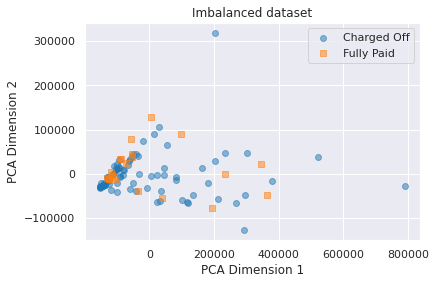

In [33]:
plot_2d_space(X_train_subset, y_train_subset, 'Imbalanced dataset')

The plot above is a visual confirmation of the imbalanced classes in our data.

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of either removing samples from the majority class (under-sampling) or adding more examples from the minority class (over-sampling). Both strategies can also be applied at the same time.

As shown below with under-sampling, we tend to loose valuable information, which can increase bias.

58 random samples removed


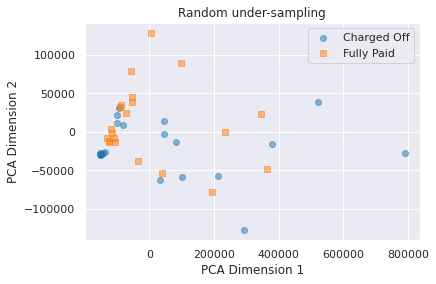

In [34]:
rus = RandomUnderSampler()
X_train_subset_rus, y_train_subset_rus= rus.fit_resample(X_train_subset, y_train_subset)

print(X_train_subset.shape[0] - X_train_subset_rus.shape[0], 'random samples removed')
plot_2d_space(X_train_subset_rus, y_train_subset_rus, 'Random under-sampling')

In over-sampling the most naive strategy is to generate new samples by randomly sampling with replacement the current available samples, which can cause overfitting.

58 random samples added


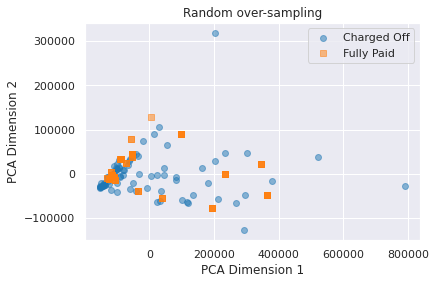

In [35]:
ros = RandomOverSampler()
X_train_subset_ros, y_train_subset_ros = ros.fit_resample(X_train_subset, y_train_subset)
print(X_train_subset_ros.shape[0] - X_train_subset.shape[0], 'random samples added')
plot_2d_space(X_train_subset_ros, y_train_subset_ros, 'Random over-sampling')

A number of more sophisticated resapling techniques have been proposed in the scientific literature, especially using the Python library imbalanced-learn [7]. SMOTE (Synthetic Minority Oversampling TEchnique) consists of creating new samples for the minority class, by picking a sample from that class and computing the k-nearest neighbors, then adding a new sample between the chosen sample and its neighbors.

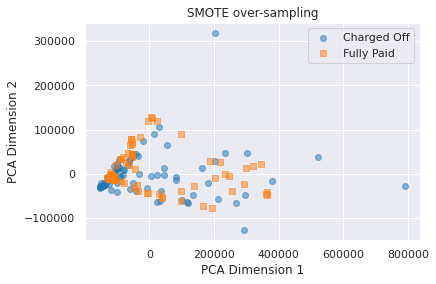

In [36]:
smote = SMOTE(sampling_strategy='minority')
X_train_subset_sm, y_train_subset_sm = smote.fit_resample(X_train_subset, y_train_subset)

plot_2d_space(X_train_subset_sm, y_train_subset_sm, 'SMOTE over-sampling')

**We will use SMOTE to balance our training dataset.** 

In [37]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
print('The Charged-Off to Fully Paid ratio in the balanced training set is now: ', len(y_train[y_train==0])/len(y_train[y_train==1]))

The Charged-Off to Fully Paid ratio in the balanced training set is now:  1.0


### Model-based features selection

**Insights on features importance**

Looking at the results above, we can bring in following conclusions:

- The term is the most important element each investor has to care about. 68-months loans are highly risky.
- The purpose of loan for credit cards payment brings more confidence to an investor.
- Borrowers who have 10 or more years verified working experience are the most trustworthy investment.
- Home ownership plays a significant role.
- The state of California is a significant factor to be considered when looking at the likelihood of Charged-Off
- Lenders should look at financial KPIs such as inq_last_6mths, num_tl_op_past_12m and acc_open_past_24mths; not just at FICO score, which are less relevant than these KPIs.
- Debt-to-income ratio and annual income can be missleading, and shoudn't be always considered as the most important factors.
- The time of the year when the loan is requested is not so relevant.


We will use classifiers on the training dataset in order to get a better understanding on how features are related to loan outcome as fully paid or unpaid. This will help us reducing the dimensionality of our data by selecting the most important features.

In [39]:
randomf = RandomForestClassifier(n_estimators=100, max_depth=None, oob_score=True).fit(X_train, y_train)

In [40]:
print('Accuracy, Training Set: {0:0.2%}'.format(randomf.score(X_train, y_train)))
print('OOB Score, Training Set: {0:0.2%}'.format(randomf.oob_score_))
print('Accuracy, Validation Set: {0:0.2%}'.format(randomf.score(X_val, y_val)))

Accuracy, Training Set: 100.00%
OOB Score, Training Set: 87.64%
Accuracy, Validation Set: 79.89%


The random forest is clearly overfit, and is obviously picking the majority class in the validation set.

Below we have a ranking of features as computed by our random forest, depending on their Gini importance in the prediction of loan outcome.

In [41]:
feature_importances = pd.DataFrame(randomf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False).reset_index().rename(columns={'index':'feature'})
feature_importances.head(10)

,feature,importance
0,term,0.040835
1,inq_last_6mths,0.032203
2,grade_B,0.027779
3,num_tl_op_past_12m,0.024517
4,percent_bc_gt_75,0.020947
5,fico_range_high,0.020251
6,acc_open_past_24mths,0.019361
7,loan_amnt,0.017740
8,mths_since_recent_inq,0.017714
9,dti,0.016818


**Important Features**

We will now use SKLearn meta-transformet SelectFromModel to discard irrelevant features using the features importance produced by our random forest.

In [42]:
fs_model = SelectFromModel(randomf, prefit=True)
outcome = fs_model.get_support()
features_list_orig = X.columns.values
features_list_new = []
for i in range(0,len(features_list_orig)):
    if outcome[i]:
        features_list_new.append(features_list_orig[i])
print('{} features were selected from the {} original hot-encoded ones:'.format(len(features_list_new), len(features_list_orig)))
print('')
print(features_list_new)

105 features were selected from the 793 original hot-encoded ones:

['acc_open_past_24mths', 'all_util', 'annual_inc', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length_1', 'emp_length_10', 'emp_length_2', 'emp_length_3', 'emp_length_4', 'emp_length_5', 'emp_length_6', 'emp_length_7', 'emp_length_8', 'emp_length_9', 'fico_range_high', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'issue_m_Aug', 'issue_m_Dec', 'issue_m_Feb', 'issue_m_Jan', 'issue_m_Jul', 'issue_m_Jun', 'issue_m_Mar', 'issue_m_May', 'issue_m_Nov', 'issue_m_Oct', 'issue_m_Sep', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mth

In [43]:
loan_variables_selected = []
for col in df_loan_accepted_census_cleaned.columns:
    if len([s for s in features_list_new if s.startswith(col)])>0:
        loan_variables_selected.append(col)

print('After hot-decoding, they corresponds to the following {} features from the original dataset.'.format(len(loan_variables_selected)))
print('')
print(loan_variables_selected)

After hot-decoding, they corresponds to the following 60 features from the original dataset.

['loan_amnt', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_bc_sats', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pc

**Design Matrix with important features**

We can now create the new design matrix using the identified important features.

In [44]:
print("Number of predictors after one-hot encoding is: ",X_train.shape[1])

Number of predictors after one-hot encoding is:  793


In [45]:
X_train = fs_model.transform(X_train)
X_val = fs_model.transform(X_val)
X_test = fs_model.transform(X_test)

In [46]:
print("Number of predictors after feature selection is ", X_train.shape[1])

Number of predictors after feature selection is  105


**Principal Components Analysis**

We are interested in reducing the dimension of our data further by analysing its principal components. This will allow us to compress the important features into a reduced number of components.

We first start with scaling the data.

In [47]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

We decompose the scaled data with PCA

In [48]:
n = X_train.shape[1]
pca_fit = PCA(n).fit(X_train_scaled)

In the plot below, we see that the dimension can be reduced to the number of components which explain at least 90% of variance in the data.

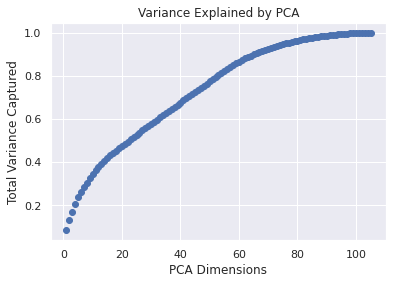

In [49]:
pca_var = np.cumsum(pca_fit.explained_variance_ratio_)
plt.scatter(range(1,n+1),pca_var)
plt.xlabel("PCA Dimensions")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

We can now rebuild our design matrix using the PCA components.

In [50]:
pca_fit = PCA(25).fit(X_train_scaled)
X_train_pca = pca_fit.transform(X_train)
X_val_pca = pca_fit.transform(X_val)
X_test_pca = pca_fit.transform(X_test)
X_train_scaled_pca = pca_fit.transform(X_train_scaled)
X_val_scaled_pca = pca_fit.transform(X_val_scaled)
X_test_scaled_pca = pca_fit.transform(X_test_scaled)

**Helper function for Design Matrix**

We summarize the above code in the function below, which create all design matrices need for our models.

In [51]:
def get_design_matrices(df, variables = ['loan_amnt', 'term', 'sub_grade', 'grade', 'emp_length', 'home_ownership',
           'annual_inc', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
           'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
           'mths_since_last_record', 'open_acc', 'pub_rec',
            'total_acc', 'collections_12_mths_ex_med',
           'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
           'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct',
           'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
           'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
           'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
           'num_accts_ever_120_pd', 'num_bc_sats',
           'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats',
           'num_tl_120dpd_2m',  'num_tl_90g_dpd_24m',
           'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
           'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort',
           'total_bc_limit', 'total_il_high_credit_limit','earliest_cr_line']):
    
    # raw data
    df_loan = df.copy()
    df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]
    df_loan = df_loan[variables]
    # hot encoding
    df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)
    df_loan.loan_status = df_loan.loan_status.astype('int')
    df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)
    df_loan = pd.get_dummies(df_loan, columns=['emp_length', 'home_ownership','purpose',
                                               'grade', 'sub_grade','earliest_cr_line'], drop_first=True)
    # design matrix
    X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)
    X_test_df = X_test
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
    # upsampling
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_val, y_val = smote.fit_resample(X_val, y_val)
    # features selection
    randomf = RandomForestClassifier(n_estimators=100, max_depth=None, oob_score=True).fit(X_train, y_train)
    fs_model = SelectFromModel(randomf, prefit=True)
    X_train = fs_model.transform(X_train)
    X_val = fs_model.transform(X_val)
    X_test = fs_model.transform(X_test)
    # scaling
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    # pca transform
    pca_fit = PCA(.9).fit(X_train_scaled)
    X_train_pca = pca_fit.transform(X_train)
    X_val_pca = pca_fit.transform(X_val)
    X_test_pca = pca_fit.transform(X_test)
    X_train_scaled_pca = pca_fit.transform(X_train_scaled)
    X_val_scaled_pca = pca_fit.transform(X_val_scaled)
    X_test_scaled_pca = pca_fit.transform(X_test_scaled)
    return X_test_df, X_train, y_train, X_val, y_val, X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled, X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca

In [52]:
X_test_df, X_train, y_train, X_val, y_val, X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled,X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca = get_design_matrices(df_loan_accepted_census_cleaned)

## Classification Models

In the previous section we used a model-based approach for identifying the important features which most probably determine the failure or success of a loan.

Using the features selected, we will now investigate the performance of several models on the validation set via cross-validation. Each model will be trained on the training set. We will also check if dimension reduction via PCA improves the accuracy. 

At the end we will investigate if ensemble technique via stacking of base learners improves classification results.


### Scoring

In classification problems, we can distinguish between the following metrics, whereby **the positive class is Charge Off** and **the negative class is Fully Paid**:

- **Recall or Sensitivity or TPR (True Positive Rate)**: Number of loans correctly identified as positive (fully paid) out of total true positives - TP/(TP+FN)
    
- **Specificity or TNR (True Negative Rate)**: Number of loans correctly identified as negative (charged-off) out of total negatives - TN/(TN+FP)

- **Precision**: Number of loans correctly identified as positive (fully paid) out of total items identified as positive - TP/(TP+FP)
    
- **False Positive Rate or Type I Error**: Number of loans wrongly identified as positive (fully paid) out of total true negatives - FP/(FP+TN)
    
- **False Negative Rate or Type II Error**: Number of loans wrongly identified as negative (charged-off) out of total true positives - FN/(FN+TP)

- A **Confusion Matrix**: visual representation of the number of TP, TN, FP and FN.

- **Accuracy**: Percentage of total items classified correctly - (TP+TN)/(N+P)

- **F1 Score**: Harmonic mean of precision and recall given by - F1 = 2xPrecisionxRecall /(Precision + Recall)

- **ROC-AUC Score**: Area under curve of sensitivity (TPR) vs. specificity (TNR).

- **Log-loss**: Probabilistic confidence of accuracy. High value of log-loss means that the absolute probabilities have big difference from actual labels.  

**Scoring in investment strategy**

Insights from [8] were used in this section.

If we choose an investment strategy that uses absolute probabilistic difference, then we will  look at log-loss with care. If the final class prediction is the most important outcome and we don’t want to tune probability threshold, we will rather use AUC score. But if the threshold is well tuned, then F1 will be the scoring to use.

In loan classification, where positive labels (charged-offs) are few, we would like our model to predict positive classes correctly and hence we will sometime prefer those models which are able to classify these positive labels. Log-loss usually fails to identify model which produces too many false negatives because the log-loss function is symmetric and does not differentiate between classes.  Both F1 score and ROC-AUC score can perform well for class imbalance. F1 is better suit for situations where the negative class is small. Since an investor would care more about the minority class (charged-off loans) in number independent of the fact whether it is positive or negative, then **we think that ROC-AUC score would make sense as benchmark measure.**

**Helper functions for scoring metrics**

The source code from [9] was adjusted in the functions below.

In [53]:
# dataframe where we track all cross-validation scoring metrics
df_cv_scores = pd.DataFrame({'model':['dummy'], 'accuracy':[0], 'f1':[0], 'roc_auc':[0]}, 
                            columns=['accuracy','f1','roc_auc'], index=['model'])
df_cv_scores_pca = df_cv_scores.copy()

df_y_pred_probas = pd.DataFrame() 
df_y_preds = pd.DataFrame() 

In [54]:
# function adjusts class predictions based on the prediction threshold
def adjust_proba(probs, threshold):
    return [1 if proba >= threshold else 0 for proba in probs]

In [55]:
# function for computing 5-fold cross-validation scoring scores
def predict_evaluate_cv(model, X, y, df_cv_scores):
    cv = StratifiedKFold(n_splits=3, random_state=9999,shuffle=True) 
    score_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    score_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    score_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    df_cv_scores.loc[model.__class__.__name__] = [score_accuracy, score_f1, score_auc]
    print('K-fold cross-validation results on validation set:')
    print(" average accuracy is {0:0.2%}".format(score_accuracy))
    print(" average F1 is {0:0.2%}".format(score_f1))
    print(" average roc_auc is {0:0.2%}".format(score_auc))

In [56]:
# function for computing the confusion matrix
def predict_evaluate_cm(model, X, y, threshold=.5):
    model_name = model.__class__.__name__
    classes = ['Fully Paid', 'Charged-Off']
    y_true = y
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    df_y_pred_probas[model_name] = y_pred_proba
    y_pred = adjust_proba(y_pred_proba, threshold)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float')
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gray" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.rcParams["axes.edgecolor"] = "0.85"
    plt.show()

In [57]:
# function for compution the roc plot
def predict_evaluate_roc(model, X, y, threshold=.5):
    y_pred = model.predict(X)
    model_name = model.__class__.__name__
    df_y_preds[model_name] = y_pred
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)

    idx = np.min(np.where(tpr > threshold))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve - {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [58]:
# global function for fitting, cross-validating and evaluating a given classifier
def fit_predict_evaluate(model, Xtrain, ytrain, Xval, yval, df_cv_scores):
    model.fit(Xtrain, ytrain)
    print(model.__class__.__name__+":")
    print('Accuracy score on training set is {0:0.2%}'.format(model.score(Xtrain, ytrain)))
    predict_evaluate_cv(model, Xval, yval, df_cv_scores)
    predict_evaluate_cm(model, Xval, yval)
    predict_evaluate_roc(model, Xval, yval)
    return model

## Decision Tree

In [59]:
dt_model = DecisionTreeClassifier(max_depth = None)

DecisionTreeClassifier:
Accuracy score on training set is 100.00%
K-fold cross-validation results on validation set:
 average accuracy is 78.98%
 average F1 is 79.27%
 average roc_auc is 79.04%


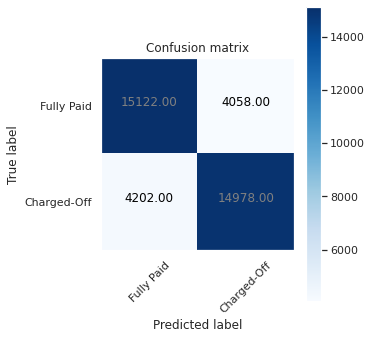

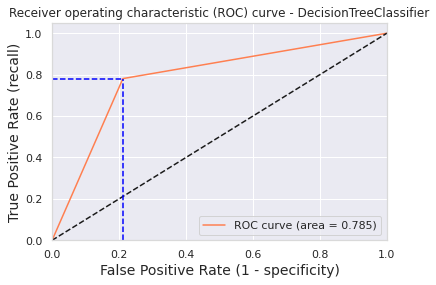

Using a threshold of 1.000 guarantees a sensitivity of 0.781 and a specificity of 0.788, i.e. a false positive rate of 21.16%.


In [60]:
dt_model = fit_predict_evaluate(dt_model, X_train, y_train, X_val, y_val, df_cv_scores)

## Logistic Regression

We will start with a simple logistic regression model for predicting loan charge-off. The penalty parameter is found via cross-validation on the training set.

In [61]:
log_reg = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )

LogisticRegressionCV:
Accuracy score on training set is 91.96%
K-fold cross-validation results on validation set:
 average accuracy is 86.31%
 average F1 is 85.22%
 average roc_auc is 91.79%


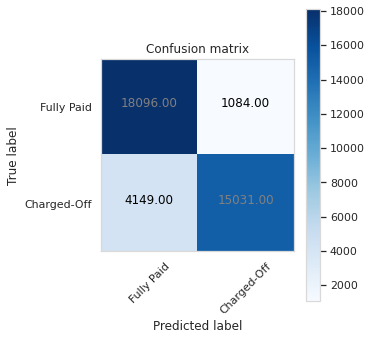

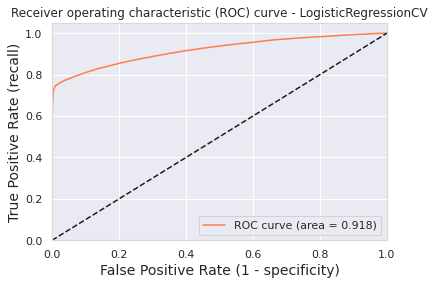

Using a threshold of 0.980 guarantees a sensitivity of 0.512 and a specificity of 1.000, i.e. a false positive rate of 0.01%.


In [62]:
log_reg = fit_predict_evaluate(log_reg, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

**Logistic Regression with PCA**

LogisticRegressionCV:
Accuracy score on training set is 91.38%
K-fold cross-validation results on validation set:
 average accuracy is 85.89%
 average F1 is 84.92%
 average roc_auc is 91.35%


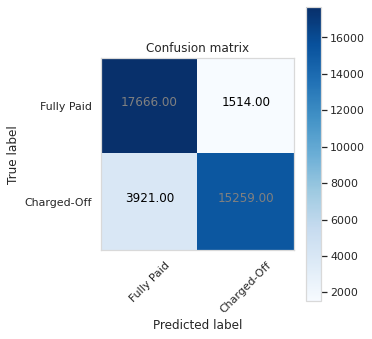

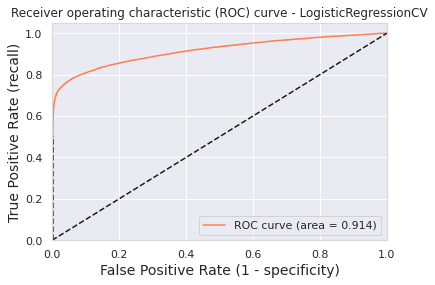

Using a threshold of 0.828 guarantees a sensitivity of 0.504 and a specificity of 0.998, i.e. a false positive rate of 0.16%.


In [63]:
log_reg_pca = fit_predict_evaluate(log_reg, X_train_scaled_pca, y_train, X_val_scaled_pca, y_val, df_cv_scores_pca)

PCA causes a decrease in average AUC.

## Random Forest

We will now rebuilt our random forest classifier, this time using the important features.

In [64]:
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=20)

RandomForestClassifier:
Accuracy score on training set is 98.48%
K-fold cross-validation results on validation set:
 average accuracy is 87.76%
 average F1 is 86.72%
 average roc_auc is 93.56%


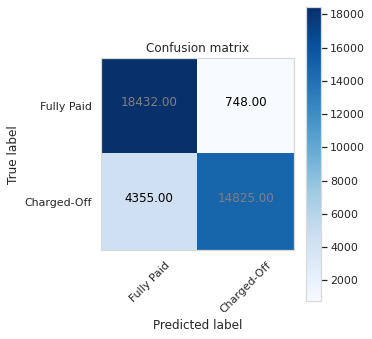

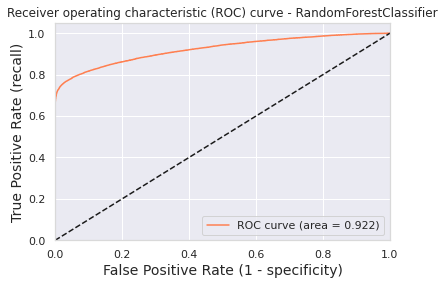

Using a threshold of 0.862 guarantees a sensitivity of 0.500 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [65]:
randomf_optim = fit_predict_evaluate(randomf_optim, X_train, y_train, X_val, y_val, df_cv_scores)

The random forest classifier gives the best accuracy so far.

## Boosting

In this section, we try the boosting technique for loan default prediction.

In [66]:
ab_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7), n_estimators=60, learning_rate=0.05)

AdaBoostClassifier:
Accuracy score on training set is 88.19%
K-fold cross-validation results on validation set:
 average accuracy is 86.68%
 average F1 is 85.52%
 average roc_auc is 92.03%


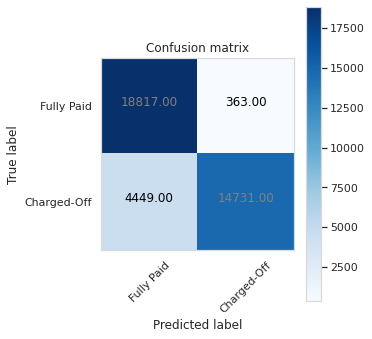

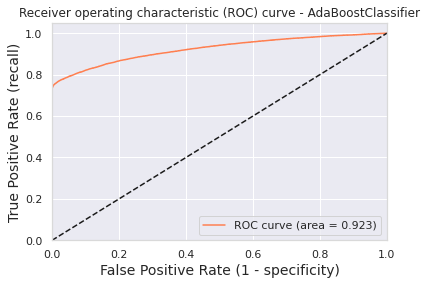

Using a threshold of 0.962 guarantees a sensitivity of 0.502 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [67]:
ab_model = fit_predict_evaluate(ab_model, X_train, y_train, X_val, y_val, df_cv_scores)

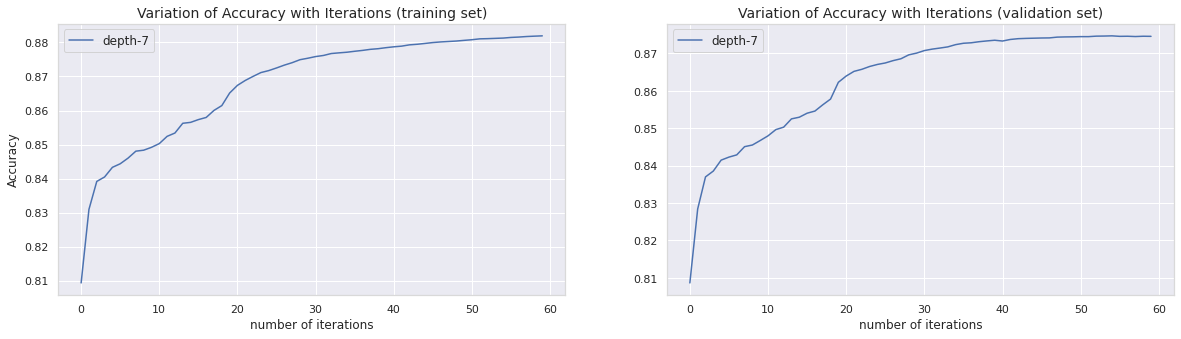

In [68]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
train_scores = list(ab_model.staged_score(X_train,y_train))
test_scores = list(ab_model.staged_score(X_val, y_val))
ax[0].plot(train_scores,label='depth-{}'.format(7))
ax[1].plot(test_scores,label='depth-{}'.format(7))
ax[0].set_xlabel('number of iterations', fontsize=12)
ax[1].set_xlabel('number of iterations', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_title("Variation of Accuracy with Iterations (training set)", fontsize=14)
ax[1].set_title("Variation of Accuracy with Iterations (validation set)", fontsize=14)
ax[0].legend(fontsize=12);
ax[1].legend(fontsize=12);    

### XG Boosting

In [69]:
xgb_model = XGBClassifier(learningrate =0.05, nestimators=100,
                    maxdepth=4, minchildweight=4, subsample=0.8, colsamplebytree=0.8,
                    objective= 'binary:logistic',
                    nthread=3,
                    scaleposweight=2,
                    seed=27)

XGBClassifier:
Accuracy score on training set is 86.74%
K-fold cross-validation results on validation set:
 average accuracy is 86.71%
 average F1 is 85.58%
 average roc_auc is 92.19%


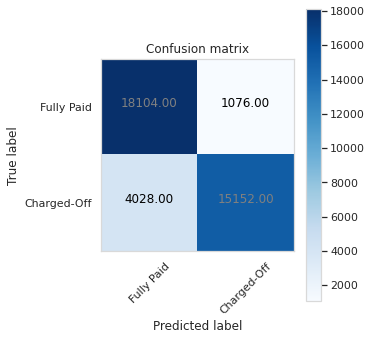

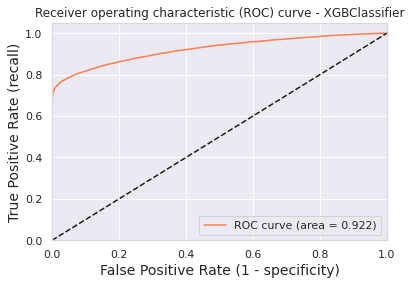

Using a threshold of 0.886 guarantees a sensitivity of 0.500 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [70]:
xgb_model = fit_predict_evaluate(xgb_model, X_train, y_train, X_val, y_val, df_cv_scores)

## SVM

In [71]:
svm_model = SVC(gamma=0.1, C=0.01, kernel="linear")

SVC:
Accuracy score on training set is 86.68%
K-fold cross-validation results on validation set:
 average accuracy is 86.70%
 average F1 is 84.96%
 average roc_auc is 91.17%


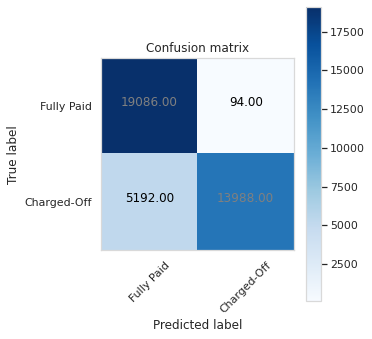

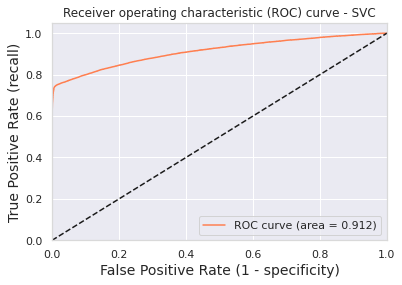

Using a threshold of 1.852 guarantees a sensitivity of 0.513 and a specificity of 1.000, i.e. a false positive rate of 0.01%.


In [72]:
svm_model = fit_predict_evaluate(svm_model, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

## QDA

In this section we try a QDA model.

In [73]:
qda_model = QuadraticDiscriminantAnalysis()

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis:
Accuracy score on training set is 67.34%


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

K-fold cross-validation results on validation set:
 average accuracy is 67.67%
 average F1 is 52.25%
 average roc_auc is 90.44%


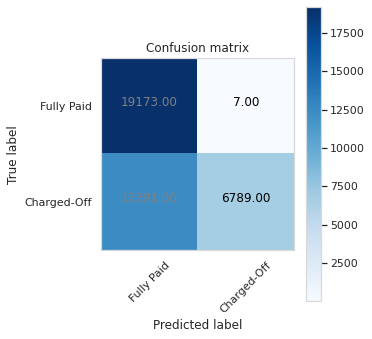

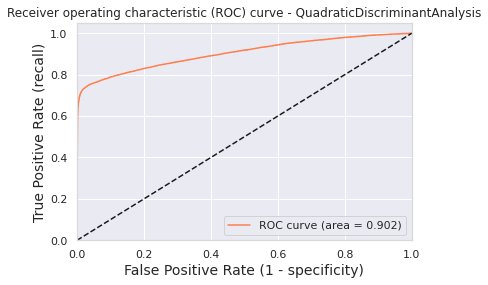

Using a threshold of 0.000 guarantees a sensitivity of 0.520 and a specificity of 0.999, i.e. a false positive rate of 0.13%.


In [74]:
qda_model = fit_predict_evaluate(qda_model, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

QuadraticDiscriminantAnalysis:
Accuracy score on training set is 82.09%
K-fold cross-validation results on validation set:
 average accuracy is 83.40%
 average F1 is 82.88%
 average roc_auc is 90.17%


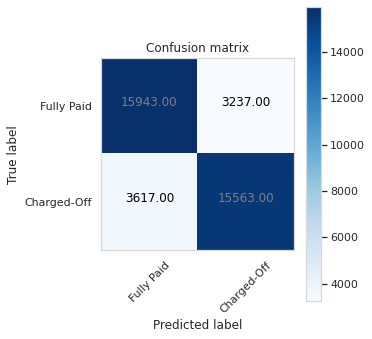

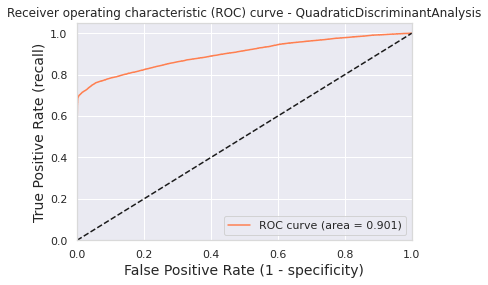

Using a threshold of 1.000 guarantees a sensitivity of 0.501 and a specificity of 1.000, i.e. a false positive rate of 0.05%.


In [75]:
qda_model_pca = fit_predict_evaluate(qda_model, X_train_scaled_pca, y_train, X_val_scaled_pca, y_val, df_cv_scores_pca)

## KNN

In [76]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

KNeighborsClassifier:
Accuracy score on training set is 91.18%
K-fold cross-validation results on validation set:
 average accuracy is 83.63%
 average F1 is 83.56%
 average roc_auc is 89.34%


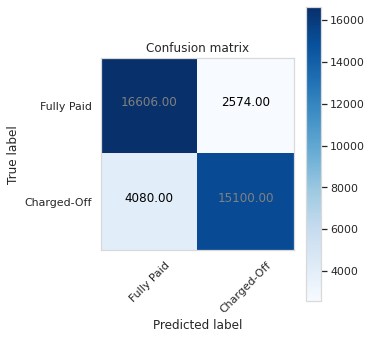

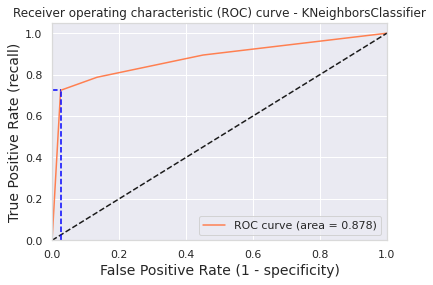

Using a threshold of 1.000 guarantees a sensitivity of 0.724 and a specificity of 0.975, i.e. a false positive rate of 2.55%.


In [77]:
knn_model = fit_predict_evaluate(knn_model, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

KNeighborsClassifier:
Accuracy score on training set is 90.89%
K-fold cross-validation results on validation set:
 average accuracy is 83.28%
 average F1 is 83.08%
 average roc_auc is 88.81%


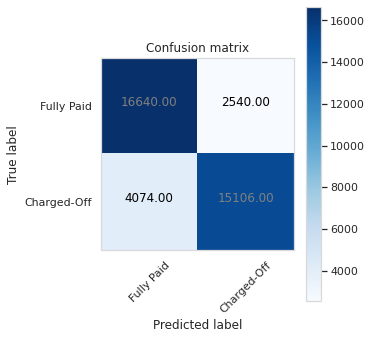

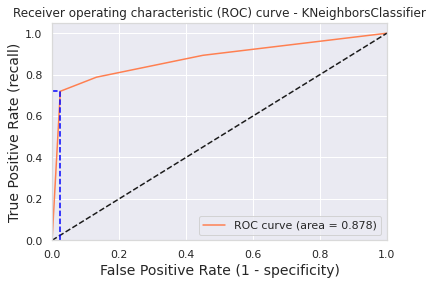

Using a threshold of 1.000 guarantees a sensitivity of 0.720 and a specificity of 0.975, i.e. a false positive rate of 2.46%.


In [78]:
knn_model_pca = fit_predict_evaluate(knn_model, X_train_scaled_pca, y_train, X_val_scaled_pca, y_val, df_cv_scores_pca)

## Multilayer Perceptron

In [79]:
mlp_model = MLPClassifier(hidden_layer_sizes=(50), batch_size=50, learning_rate='constant', learning_rate_init=0.0005, early_stopping=True)

MLPClassifier:
Accuracy score on training set is 87.30%
K-fold cross-validation results on validation set:
 average accuracy is 86.38%
 average F1 is 85.20%
 average roc_auc is 91.55%


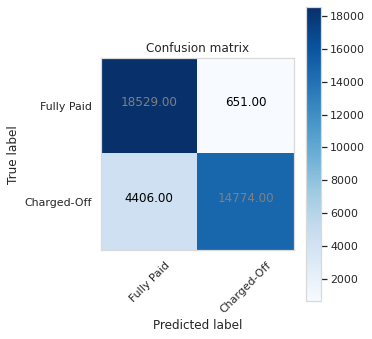

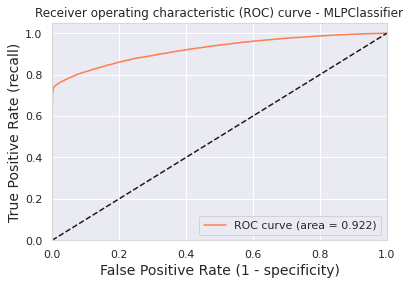

Using a threshold of 0.997 guarantees a sensitivity of 0.576 and a specificity of 1.000, i.e. a false positive rate of 0.01%.


In [80]:
mlp_model = fit_predict_evaluate(mlp_model, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

MLPClassifier:
Accuracy score on training set is 86.81%
K-fold cross-validation results on validation set:
 average accuracy is 86.02%
 average F1 is 84.85%
 average roc_auc is 91.62%


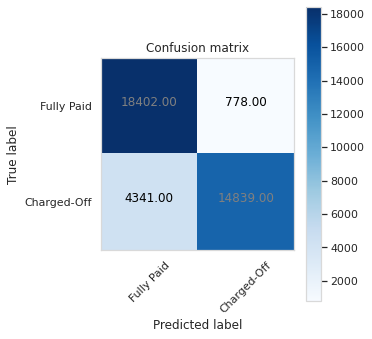

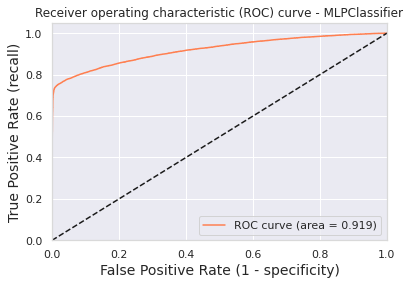

Using a threshold of 0.993 guarantees a sensitivity of 0.502 and a specificity of 0.999, i.e. a false positive rate of 0.06%.


In [81]:
mlp_model_pca = fit_predict_evaluate(mlp_model, X_train_scaled_pca, y_train, X_val_scaled_pca, y_val, df_cv_scores_pca)

## Loan Description

Some studies [10] suggest that words used on loan applications can predict the likelihood of charge-off.
In this section we use natural language processing algorithms to extract features from the loan title and description filled in by the borrower when requesting the loan. We then use a Naive Bayes classifier and a random forest for this task.

The function below performs the following preprocessingon the text data:

- lower case
- remove punctuation
- remove commonly occuring words using predefined libraries
- remove suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach

In [82]:
# source code adapted from [11]
def clean_text(text):
    # lower case
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    # remove punctuation
    text = text.str.replace('[^\w\s]','') 
    # remove stop words    
    stop = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # correct spelling
    #from textblob import TextBlob
    #text = text.apply(lambda x: str(TextBlob(x).correct()))
    # lemmatization     
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return text

We first prepare the data.

In [85]:
df_desc = df_loan_accepted_census_cleaned.copy()
df_desc = df_desc[['title', 'loan_status']]. # dropped desc due to missing in data
df_desc.fillna('N/A', inplace=True)
#df_desc['desc'] = df_desc['desc'] + ' - ' + df_desc['title']
df_desc = df_desc[df_desc.loan_status.isin(['Charged Off', 'Fully Paid'])]
df_desc.replace({'loan_status':{'Charged Off': 0, 'Fully Paid': 1}}, inplace=True)

The feature is the merged loan title and description, the response variable is the loan status.

In [86]:
X_desc = df_desc.title
y_desc = df_desc.loan_status
#X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(X_desc, y_desc, test_size= 0.2, random_state=13)
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(X_desc, y_desc, test_size=0.1, stratify=y_desc)
X_train_desc, X_val_desc, y_train_desc, y_val_desc = train_test_split(X_train_desc, y_train_desc, test_size=0.2, stratify=y_train_desc)

# upsampling
X_train_desc, y_train_desc = resample(X_train_desc, y_train_desc, n_samples=round(y_train.shape[0]))
X_val_desc, y_val_desc = resample(X_val_desc, y_val_desc, n_samples=round(y_val.shape[0]))
X_test_desc, y_test_desc = resample(X_test_desc, y_test_desc, n_samples=round(y_test.shape[0]))


We extract TF-IDF features. TF-IDF is the multiplication of the TF and IDF.  The IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.The TF or term frequency is the ratio of the count of a word present in a sentence, to the length of the sentence.

In [87]:
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 1),
    max_features=30000)

# fit and transform on it the training features
word_vectorizer.fit(X_train_desc)
X_train_desc_features = word_vectorizer.transform(X_train_desc)

#transform the val and test features to sparse matrix
X_val_desc_features = word_vectorizer.transform(X_val_desc)
X_test_desc_features = word_vectorizer.transform(X_test_desc)

In [88]:
print("Our training data has {} loans, each with {} text features.".format(X_train_desc_features.shape[0], 
                                                                           X_train_desc_features.shape[1]))

Our training data has 153436 loans, each with 2412 text features.


**Naive Bayes**

The multinomial Naive Bayes classifier is suitable for classification with discrete features and fractional counts such as tf-idf.

In [89]:
nb_model = MultinomialNB()

MultinomialNB:
Accuracy score on training set is 80.28%
K-fold cross-validation results on validation set:
 average accuracy is 80.08%
 average F1 is 88.92%
 average roc_auc is 53.40%


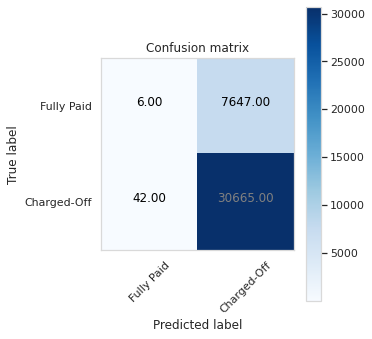

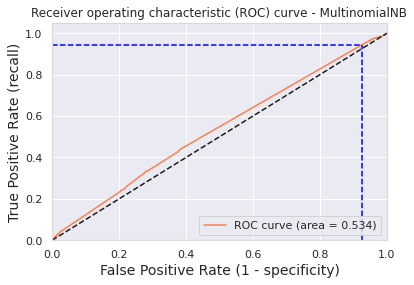

Using a threshold of 0.784 guarantees a sensitivity of 0.943 and a specificity of 0.076, i.e. a false positive rate of 92.45%.


In [90]:
nb_model = fit_predict_evaluate(nb_model, X_train_desc_features, y_train_desc, X_val_desc_features, y_val_desc, df_cv_scores)

Both Naive Bayes and random forest did not find enough information that would clearly distinguish the two classes of loans.

# RESULTS

## Model Selection

### Scoring benchmark

All models investigated in this project are compared in the table below. The performance was evaluated in a out-of-sample manner on the validation set using 3-folds cross-validation.

For each model, we can compare different metrics (accuracy, F1, ROC_AUC). We are also able to compare models using the metric ROC_AUC, which reflect their performance when we set probability cutoff at 50%. 

The scoring results is summarised below.

In [91]:
df_cv_scores_report = df_cv_scores.copy()
df_cv_scores_report.drop('model', inplace=True, errors='ignore')
df_cv_scores_report.sort_values(by=['roc_auc'], ascending=False, inplace=True)
df_cv_scores_report.reset_index(inplace=True)
df_cv_scores_report.rename(columns={'index':'model'}, inplace=True)
df_cv_scores_report

,model,accuracy,f1,roc_auc
0,RandomForestClassifier,0.877633,0.867189,0.935588
1,XGBClassifier,0.867101,0.855754,0.921917
2,AdaBoostClassifier,0.866814,0.855233,0.920293
3,LogisticRegressionCV,0.863139,0.852220,0.917900
4,MLPClassifier,0.863764,0.852029,0.915494
5,SVC,0.867023,0.849577,0.911746
6,QuadraticDiscriminantAnalysis,0.676668,0.522517,0.904397
7,KNeighborsClassifier,0.836288,0.835631,0.893365
8,DecisionTreeClassifier,0.789807,0.792668,0.790433
9,MultinomialNB,0.800834,0.889185,0.534031


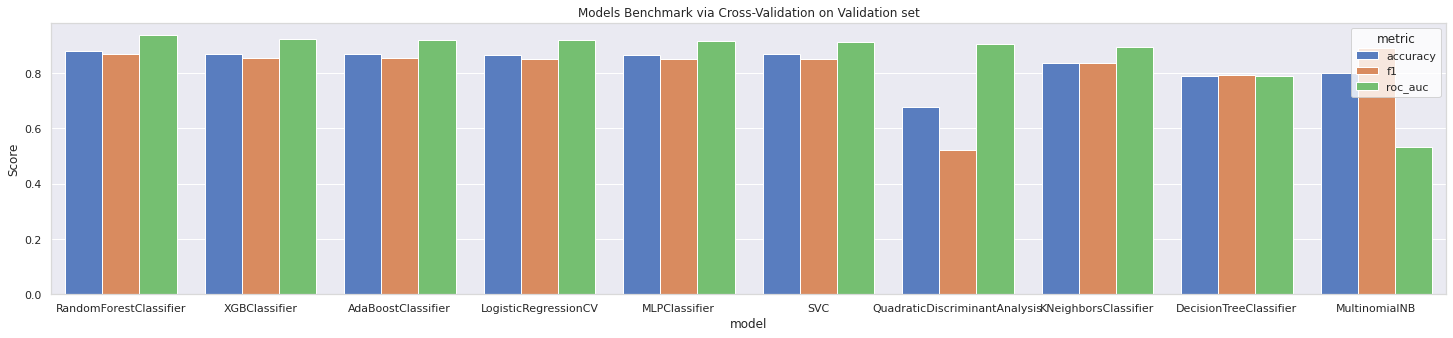

In [92]:
df_cv_scores_melt = pd.melt(df_cv_scores_report, id_vars=['model'], var_name='metric', value_name='score')
fig, ax = plt.subplots(1,1,figsize=(25,5))
sns.set(style="whitegrid")
sns.barplot(x="model", y="score", hue="metric", data=df_cv_scores_melt, palette="muted", ax=ax)
ax.set_title("Models Benchmark via Cross-Validation on Validation set")
ax.set_ylabel("Score");

Some models were also evaluated on a scaled version of the data (with features standardized with zero mean and standard deviation 1). The results below show that standardizing the data did not improve the prediction accuracy.

# Final Model

### Random Forest Classifier is the best performer

The benchmark perform

**Threshold tuning**

It is more flexible to predict probabilities of a loan belonging to each class rather than predicting classes directly. Probabilities may be interpreted using different thresholds that allow us to trade-off concerns in the errors made by the model, such as the number of false negatives which outweighs the cost of false positives. We will use ROC Curves and Precision-Recall curves as diagnostic tools.

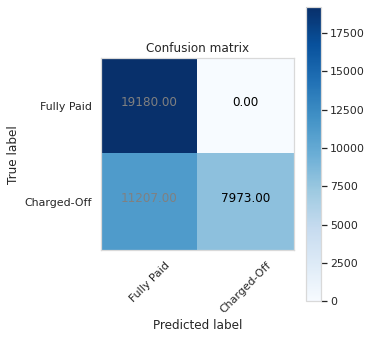

In [107]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=.9)

As shown above if we set the threshold too high, we end up with a very bad prediction of Charge Offs. Although we predict all Fully Paid loans right, our investor will have to deal with a very high number of loans failures.

Below, by choosing a lower threshold the investor will miss some business opportunities, but will secure his finance by correctly identifying those loans with high risk of failures.

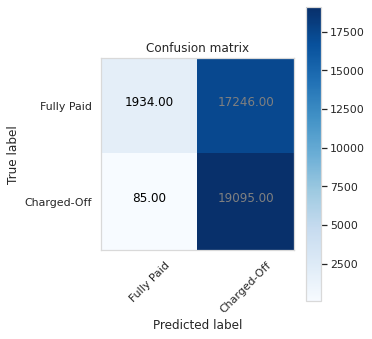

In [108]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=.1)

By choosing a **threshold of 0.3**, we have ca. 12% of false positives. These are loans which have charged off but our model failed to identify them. We will assume that such a threshold is an acceptable compromise for our investment strategy. 

In [109]:
threshold = .3

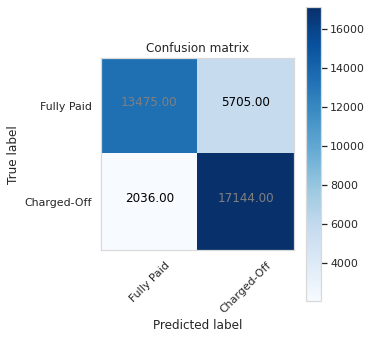

In [110]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=threshold)

### ROC benchmark

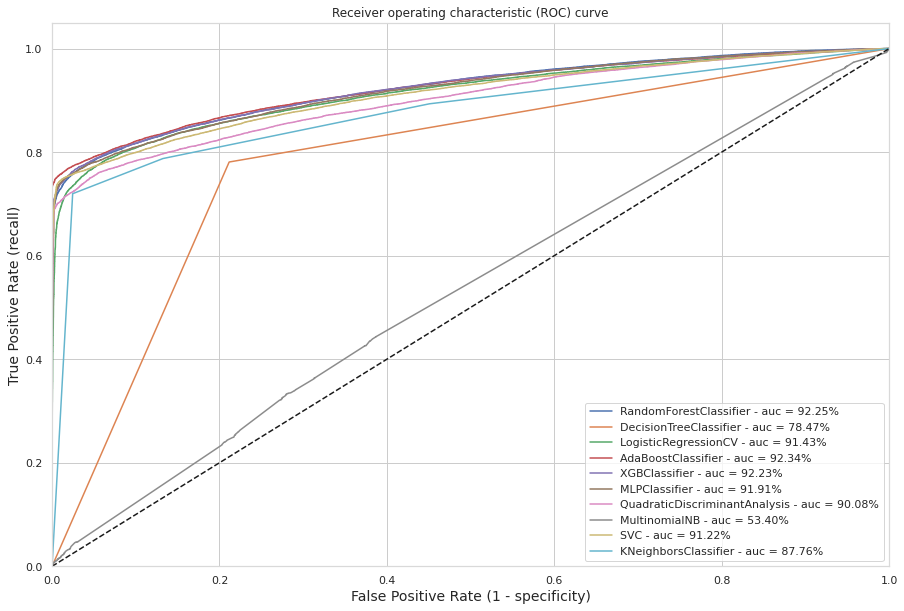

In [111]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
models = [randomf_optim, dt_model, log_reg, ab_model, xgb_model, mlp_model, qda_model, nb_model, svm_model, knn_model]
for model in models:
    model_name = model.__class__.__name__
    if  model_name == 'RandomForestClassifier' or \
        model_name == 'XGBClassifier' or \
        model_name == 'AdaBoostClassifier' or \
        model_name == 'DecisionTreeClassifier':
        Xval = X_val
        yval = y_val
    elif model_name == 'MultinomialNB':
        Xval = X_val_desc_features
        yval = y_val_desc
    else:
        Xval = X_val_scaled
        yval = y_val
    y_pred = df_y_preds[model_name]
    y_pred_proba = df_y_pred_probas[model_name]
    [fpr, tpr, thr] = roc_curve(yval, y_pred_proba)
    
    ax.plot(fpr, tpr, label='{0} - auc = {1:.2%}'.format(model_name,auc(fpr, tpr)))
    if model_name == 'RandomForestClassifier':
        idx = np.min(np.where(tpr > threshold))
        ax.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', label='', color='b')
        ax.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', label='', color='b')
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Combining all predictions and creating a heatplot of their correlations gives us the following view. Supoprt Vector Machine is excluded from this plot since it computes distances instead of probabilities, which can only be estimated at the cost of extensive computation. 

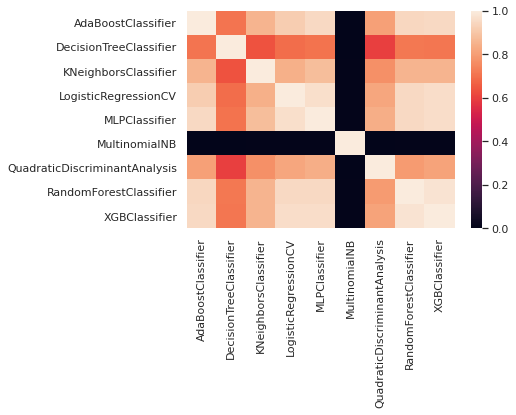

In [112]:
df_y_val_prob = df_y_pred_probas[df_y_pred_probas.columns.difference(['SVC'])]
sns.heatmap(df_y_val_prob.corr())
plt.show()

It is pretty clear from these visualizations that the predictions of Naive Bayes classifier, Multilayer Perceptron, QDA, Logistic Regression are very opposite from predictions of other models. The tree-based classifiers are producing rvery similar results to each other, showing their similar internal structure. The predictions of KNN classifier are also very less correlated with the predictions of other classifiers. 

Below we compute the Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores using the average probabilities from our classifiers (excluding support vector machine).

In [113]:
y_val_pred_avg = adjust_proba(df_y_val_prob.mean(axis=1), threshold)
avg_score = roc_auc_score(y_val, y_val_pred_avg)

In [114]:
y_val_pred_rf = df_y_preds['RandomForestClassifier']
rf_score = roc_auc_score(y_val, y_val_pred_rf)

In [115]:
print("With probability threshold {} on validation set", threshold)
print("  ROC AUC score obtained by averaging probabilities of several classifiers is {0:.2%}".format(avg_score))
print("  ROC AUC score obtained by the Random Forest Classifier is {0:.2%})".format(rf_score))

With probability threshold {} on validation set 0.3
  ROC AUC score obtained by averaging probabilities of several classifiers is 74.88%
  ROC AUC score obtained by the Random Forest Classifier is 86.70%)


This result suggests that an Ensemble technique, e.g. Stacking would most probably not bring considerable improvment in the reduction of false negatives (loan predicted fully paid, but in reality charge off). 

# Investment Strategy

## Motivation

Accuracy, ROC, MSE, are terms familiar to a data scientist but, probably not terms an investor would easilly understand. One of the most common metrics to evaluate an investment is Return On Investment (ROI) which can be defined as (FinalValue - InitialValue)/InitialValue. For example, we invest \\$1000 and after a year, our investment is worth \$1200, then our annual ROI is 20%.

We will test our strategy using the 2015 LC loan stats data. 15.68% of the loans in the dataset are classified as False (failed).<br><br>
The goal is to select loans such that the failure rate is less than 15.68%. At this point we are assumung that a selection of loans from the same grade (same interest rate) with a failure rate lower than 15.68% will yield a better ROI for the investor. This needs to be verified and involves looking at the costs of failed loans.<br><br>
The Random Forest model that was developed in the previous section is used here since it clearly outperformed many different models we have been trying based on the ROC_AUC metric. <br><br>
A failure rate of 15.68% or more which sounds excellent, but is indeed no better than a random loan selection.<br><br>
Our Business Objective is to minimize the percentage of Loans selected which are False. This is referred to as the "False Discovery Rate" (FDR). It is equal to 1 - PPV (Positive Prediction Value) [13]. We may reject many loans which are good loans; however, we do not want to select loans that are bad ones.<br><br>

As we saw in the confusion matrix in the previous sections, let's think about what happens when we reduce the threshold from, 50% to 30%. In this case, some loans which would have normally be classified as Fully Paid will be classified as Charge Off. However, the loans that are selected have a higher probability of truly being Charge Off (actual value). Similarly the probability of a selected loan failing will drop. Hence decreasing the threshold increases the quality of the selection with the trade-off that we are throwing away (not selecting) loans which would normally be classified as Good. 

In the next sections we will evaluate this strategy in loans of the same subgrade, as assigned by the LendingClub.

## Prediction

Now it is time to evaluate our model on the left-out data set, which has not been used neither for training nor for cross-validation.

In [102]:
y_test_pred = randomf_optim.predict_proba(X_test)[:, 1]
y_test_pred = adjust_proba(y_test_pred, threshold)
test_score = accuracy_score(y_test, y_test_pred)
print("With probability threshold {0}, the Classification Accuracy Score on Test is {1:.2%}".format(threshold, test_score))

With probability threshold 0.3, the Classification Accuracy Score on Test is 67.40%


These are compeling results showing that the model separates fully paid from charge-off loans with high accuracy on unseen data.

In [103]:
print("Without our model, the accuracy on Test would have been {0:.2%}".format(1-len(y_test[y_test==1])/len(y_test)))

Without our model, the accuracy on Test would have been 80.04%


## Evaluation

The function below fits a predictive model with a subset of data depending on the invesment strategy (sub grades and term), and it displays the accuracy of our predictions, as well as an estimation of the Return Of Investment campared to the default strategy offered by LendingClub.

In [104]:
def simulate_strategy(df, X_test_df, X_test, sub_grades=['A1'], terms=[36], threshold=.3, verbose=True):
    # indexes of test loans in the original data frame containing all loans
    test_idx = X_test_df.index.values
    # test loans from the original data frame containing all loans
    df_test = df.loc[test_idx]
    # subset of candidate test loans, filtered by specific sub grades and terms
    df_test_candidates = df_test[(df_test.sub_grade.isin(sub_grades)) & (df_test.term.isin(terms))]
    if df_test_candidates.shape[0] == 0:
        return 0, 0
    # indexes of candidate test loans
    df_test_candidates_idx = df_test_candidates.index.values
    # candidate test loans in the design matrix
    X_test_candidates = X_test[df_test.index.isin(df_test_candidates_idx)]
    y_test_candidates = y_test[df_test.index.isin(df_test_candidates_idx)]
    # prediction of loan status for candidate test loans
    y_test_candidates_pred = randomf_optim.predict_proba(X_test_candidates)[:, 1]
    y_test_candidates_pred = adjust_proba(y_test_candidates_pred, threshold)
    test_score = accuracy_score(y_test_candidates, y_test_candidates_pred)
    df_test_candidates = df_test_candidates.assign(loan_status_predicted = y_test_candidates_pred)
    # calculate the ROI for each candidate test loan
    df_test_candidates['roi'] = df_test_candidates.apply(calc_roi, axis=1)
    # calculate average annual ROI for the Lender's CLub 'Automatic' selection
    roi_lc = df_test_candidates['roi'].mean()
    # calculate average annual ROI for loans which our model predicts they will be fully paid (prediction is 0)
    roi_randomf = df_test_candidates[df_test_candidates.loan_status_predicted==0]['roi'].mean()
    # display results
    if verbose:
        print('Investment on sub grades {} and terms {}:'.format(sub_grades, terms))
        print('')
        print("  With probability threshold {0}, the selected loans were classified with accuracy {1:.2%}".format(threshold, test_score))
        print("  Average annual ROI for Lending Club is {}%".format(round(roi_lc,2)))
        print("  Average annual ROI for our model is {}%".format(round(roi_randomf,2)))
    return roi_lc, roi_randomf, df_test_candidates

In [105]:
#
# Calculate ROI. Monthly data and much better documentation from Lender's Club is needed
# to precisely calculate ROI. Still, this is not bad!
#
def calc_roi(row):
# We assume here that  charge-offs are made in the last month
    def insuf_payment(factor, i):

        loss = int_rcvd + pmt_rcvd + net_recoveries +late_fees - owed
        factor *= (1 + loss/principal)
        factor = factor**(1/term)
        return factor**12 - 1
    
    def early_payoff(factor, i):
        return (factor**(1/(i+1)))**12 - 1 
        
    term = row.term
    int_rcvd = row.total_rec_int
    pmt_rcvd = row.total_pymnt
    principal = row.funded_amnt
    yr_int_rate = row.int_rate
    mo_int_rate = (1+yr_int_rate)**(1/12) - 1
    mo_pay = row.installment
    
    recoveries = row.recoveries
    late_fees = row.total_rec_late_fee
    fee = row.collection_recovery_fee
    
    net_recoveries = recoveries - fee
    
    owed = principal

# Calculate monthly gain (could be less than 1) while there are months to go and interest
# Could be extra interest because of hardship plans
    factor = 1

#---Beginning of For------------------------
    for i in range(0, int(term)):

        if (pmt_rcvd + .50 < mo_pay):
             return insuf_payment(factor, i)
        this_interest = owed*mo_int_rate     
        
# If not enough interest was paid to cover this month, consider loan paid off early
# and count monthly gain as (1+mo_int_rate), just like NAR

        factor *= 1 + mo_int_rate

        if (this_interest > int_rcvd):
            return early_payoff(factor, i)
            
        int_rcvd -= this_interest
        if owed < mo_pay:
            return early_payoff(factor, i)
        pmt_rcvd -= mo_pay
        owed -= mo_pay - this_interest
#---End of For-------------------------------
    return early_payoff(factor, i)

We can simulate an improved return of investment on specific loans types below.

In [106]:
roi_lc, roi_df, df_test_candidates = simulate_strategy(df_loan_accepted_census_cleaned, 
                                                               X_test_df, X_test, 
                                                               sub_grades=['D5'], 
                                                               terms=[36], 
                                                               threshold=.3) 

AttributeError: ignored

We can simulate the model on all sorts of subgrades/terms combinations

In [116]:
sub_grades = df_loan_accepted_census_cleaned.sub_grade.unique()
terms = df_loan_accepted_census_cleaned.term.unique()
df_roi = pd.DataFrame(columns=['sub_grad', 'term', 'lc_roi', 'model_roi'])
i = 0
for sub_grade in sub_grades:
    for term in terms:
        roi_lc, roi_model = simulate_roi(df_loan_accepted_census_cleaned, 
                                           X_test_df, X_test, 
                                           sub_grades=[sub_grade], 
                                           terms=[term], 
                                           threshold=threshold,
                                           verbose=False)
        df_roi.loc[i]=[sub_grade, term, roi_lc, roi_model]        
        i += 1

NameError: ignored

In [ ]:
df_roi.lc_roi.mean(), df_roi.model_roi.mean()

# Plots to check our model on fairness and discrimination

**The output of our model is the dataframe "df_test_candidates", selected loans by our model. We will use this information to our model for fairness and discrimination**

**Plot 1**

We investigate the correlation between census features and loan features.

Looking at bottom left part of the heatmap below, we can say that the correlation between selected loan's features and census features is strongly negatively correlated. 

For instance 1, Being a female, they have very low cur balance and very low credit limit.

For instance 2, A white race person can has a low value for "mo_sin_old_il_acct" and "total_bc_limit"

In [ ]:
cols1 = ['loan_status','female_pct','male_pct','White_pct','Black_pct','Native_pct','Asian_pct','Hispanic_pct','poverty_level_below_pct','employment_2016_rate']
cols2 = ['int_rate','term','dti','bc_open_to_buy','funded_amnt_inv','tot_hi_cred_lim','tot_cur_bal','annual_inc','total_bc_limit','bc_util','total_rev_hi_lim','mo_sin_old_rev_tl_op','total_bal_ex_mort','acc_open_past_24mths','mo_sin_old_il_acct']
corr = df_test_candidates[cols1 + cols2].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between loan and census information');

**Plot 2**

We investigate fairness by displaying a stripplot with the distribution of census data.

Overall it seems the likelihood of failing to fully payback loans is slightly affected by the race and gender. 
Being a black, asian, poverty level affects the probablity of payback loans.

In [ ]:
df = pd.melt(df_test_candidates[['loan_status','female_pct','male_pct','White_pct','Black_pct','Native_pct','Asian_pct','Hispanic_pct','poverty_level_below_pct','employment_2016_rate']], "loan_status", var_name="measurement")
df.head()

f, ax = plt.subplots(figsize=(10,7))
sns.despine(bottom=True, left=True)
sns.stripplot(x="value", y="measurement", hue="loan_status",
              data=df, dodge=True, jitter=True, alpha=.25,zorder=1)
sns.pointplot(x="value", y="measurement", hue="loan_status",
              data=df, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="loan status",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)
ax.set_title('Consensus data vs loan');

## Algorithmic Fairness

A high level goal of this project is addressing the ethic implications of our model along the lines of fairness and discrimination.

It is a known fact that algorithms can facilitate illegal discrimination. 

An investor wants to invest in loans with high return of investment and low risk. A modern idea is to use an algorithm to decide, based on the sliver of known information about the outcome of past loans, which future loan requests give the largest chance of the borrower fully paying it back, while achieving the best trade-off with high returns (high interest rate). Our model is such an algorithm.

There’s one problem: our model is trained on historical data, and poor uneducated people, often racial minorities or people with less working experience have a historical trend of being more likely to succumb to loan charge-off than the general population. So if our model is trying to maximize return of investment, it may also be targeting white people, people on specific zip codes, people with work experience, de facto denying opportunities for fair loans to the remaining population.

Such behavior would be illegal [15].

There could be two points of failure here: 

- we could have unwittingly encode biases into the algorithm based on a biased exploration of the data
- the data itself could encode biases due to human decisions made to create it

Although there is no definition which is widely agreed as a good definition of fairness, we will use **statistical parity** to test hypothesis of fairness on our model.

Given a sub grade and a term, assuming that the population of borrowers who applied for a loan of that term and were assigned the sub grade is called $P$, and there is a known subset $F$ of female borrowers within that population. We assume that there is some distribution $D$ over $P$ which represents the probability that any of those borrowers will be picked by our model for evaluation. Our model is a classifier $m: X \rightarrow \{0, 1\}$ that gives labels borrowers. if $m=1$ then the person will Charge Off on his loan, if $m=0$, he will fully pay his loan. The bias or **statistical imparity** of $m$ on $F$ with respect to $X, D$ is the difference between the probability that a random female borrower is labeled 1 and the probability that a random male borrower is labeled 1. If that difference is small, then we can say that our model is having statistical parity [17].


The function below measures the statistical parity of our model on protected population $F$. This metric describes how fair our model is with respect to the protected subset population. The input of the function is an array of binary values (1 if the sample is a loan requested by a female, 0 else) and a second array of binary values (1 if the model predicted that the loan will Charge Off, 0 else).  The code is adapted from [16].

In [ ]:
def statistical_parity(protected_status, loan_status_predicted):

    if len(protected_status) != len(loan_status_predicted):
        raise ValueError('Input arrays do not have same number of entries')

    indices_pos_class, = np.where(protected_status == 1)
    indices_neg_class, = np.where(protected_status == 0)

    outcomes_pos = loan_status_predicted[indices_pos_class]
    outcomes_neg = loan_status_predicted[indices_neg_class]

    if len(outcomes_pos) == 0:
        return None
    if len(outcomes_neg) == 0:
        return None
    value_discrim = np.abs(len(np.where(outcomes_pos == 1)) /
                           len(outcomes_pos) -
                           len(np.where(outcomes_neg == 1)) /
                           len(outcomes_neg))

    return value_discrim


The function below test statistical parity on a group of features of the borrowers.

In [ ]:
def model_fairness_check(df, protected_groups, fairness_threshold):
    for group in protected_groups:
        protected_status = df_test_candidates[group].apply(lambda x: 1 if x>0.5 else 0)
        loan_status_predicted = df_test_candidates['loan_status_predicted'].values
        stats_parity = statistical_parity(protected_status, loan_status_predicted)
        if stats_parity == None:
            print("Not enough data available for {}".format(group))
        else:
            if abs(stats_parity) < fairness_threshold:
                print("The model is FAIR on {} with statistical parity {}".format(group, round(stats_parity,5)))
            else:
                print("The model is NOT FAIR on {} with statistical parity {}".format(group, round(stats_parity,5)))

Now we can test the fairness of our model with regard to specifics borrowers.

In [ ]:
model_fairness_check(df_test_candidates, ['female_pct','Black_pct', 'Native_pct', 'Asian_pct','Hispanic_pct', 'household_family_pct', 'poverty_level_below_pct','Graduate_Degree_pct'], fairness_threshold=.01)

**Disparate impact** in United States labor law refers to "practices in employment, housing, and other areas that adversely affect one group of people of a protected characteristic more than another, even though rules applied by employers or landlords are formally neutral."[18]. It measures the difference that the majority and protected classes get a particular outcome. We use the function below adapted from [16] to check on disparate impact based on the legal definition of threshold of 80%. This is determined with respect to a protected class.

The input of the function is an array of binary values (1 if the sample is a loan requested by a female, 0 else) and a second array of binary values (1 if the model predicted that the loan will Charge Off, 0 else). If $\dfrac{P(male | chargeoff )}{P(female | chargeoff )} \leq 80%$ then the definition of disparate impact is satisfied. The output is True is the model demonstrates discrimination, False else. The degree of discrimation is also provided between 0 and 1.

In [ ]:
def disparate_impact(protected_status, loan_status_predicted):
    if len(protected_status) != len(loan_status_predicted):
        raise ValueError('Input arrays do not have same number of entries')

    # "positive class" are those where predictions = Charge Off
    # "majority class" are those where protected class status = 1
    
    indices_pos_class, = np.where(protected_status == 1)
    
    outcomes_pos = loan_status_predicted[indices_pos_class]

    if len(np.where(outcomes_pos == 1)) == 0:
        return None, None
    
    value_discrim = len(np.where(outcomes_pos == 0)) / len(
        np.where(outcomes_pos == 1))

    if value_discrim <= 0.8:
        is_discriminatory = True
    else:
        is_discriminatory = False

    return is_discriminatory, 1 - value_discrim

The function below disparate impact on a group of features of the borrowers.

In [ ]:
def model_disparate_impact_check(df, protected_groups):
    for group in protected_groups:
        protected_status = df_test_candidates[group].apply(lambda x: 1 if x>0.5 else 0)
        loan_status_predicted = df_test_candidates['loan_status_predicted'].values
        discriminate, level_discrimination = disparate_impact(protected_status, loan_status_predicted)
        if discriminate == None:
            print("Not enough data available for {}".format(group))
        else:
            if discriminate:
                print("The model is DISCRIMINATING on {} with level {}".format(group, round(level_discrimination,5)))
            else:
                print("The model is NOT DISCRIMINATING on {}".format(group))

Now we can test the disparate impact of our model with regard to specific borrowers.

In [ ]:
model_disparate_impact_check(df_test_candidates, ['female_pct','Black_pct', 'Native_pct', 'Asian_pct','Hispanic_pct', 'household_family_pct', 'poverty_level_below_pct','Graduate_Degree_pct'])